In [1]:
PATH_TO_REPO = '/Users/weitzenfeld/PycharmProjects/m6_public'

In [2]:
import sys
sys.path.append(PATH_TO_REPO)
from datetime import datetime
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import arviz as az
import numpy as np
import pymc as pm
import pandas as pd
import seaborn as sns

import m6_public
from m6_public.apis import eod
from m6_public.datasets import m6_dataset
from m6_public import m6_models
from m6_public.mpl_utils import percent_formatter

plt.style.use(os.path.join(m6_public.ROOT, 'etc', 'm6_public.mplstyle'))

### Pull the data from EOD
This also defines the calendar, and does some feature engineering

In [3]:
anchor_date = datetime(2023, 1, 8)

In [4]:
m6_ds = m6_dataset.Dataset(anchor_date=anchor_date)

In [5]:
df, df_earnings, df_cal = m6_ds.dataframes()

ABBV: last_day of data: 2024-06-28 00:00:00
ACN: last_day of data: 2024-06-28 00:00:00
AEP: last_day of data: 2024-06-28 00:00:00
AIZ: last_day of data: 2024-06-28 00:00:00
ALLE: last_day of data: 2024-06-28 00:00:00
AMAT: last_day of data: 2024-06-28 00:00:00
AMP: last_day of data: 2024-06-28 00:00:00
AMZN: last_day of data: 2024-06-28 00:00:00
AVB: last_day of data: 2024-06-28 00:00:00
AVY: last_day of data: 2024-06-28 00:00:00
AXP: last_day of data: 2024-06-28 00:00:00
BDX: last_day of data: 2024-06-28 00:00:00
BF-B: last_day of data: 2024-06-28 00:00:00
BMY: last_day of data: 2024-06-28 00:00:00
BR: last_day of data: 2024-06-28 00:00:00
CARR: last_day of data: 2024-06-28 00:00:00
CDW: last_day of data: 2024-06-28 00:00:00
CE: last_day of data: 2024-06-28 00:00:00
CHTR: last_day of data: 2024-06-28 00:00:00
CNC: last_day of data: 2024-06-28 00:00:00
CNP: last_day of data: 2024-06-28 00:00:00
COP: last_day of data: 2024-06-28 00:00:00
CTAS: last_day of data: 2024-06-28 00:00:00
CZR: 

In [6]:
df_cal.tail()

,period_start,period_end
period_i,,
230.0,2022-09-19,2022-10-14
231.0,2022-10-17,2022-11-11
232.0,2022-11-14,2022-12-09
233.0,2022-12-12,2023-01-06
234.0,2023-01-09,2023-02-03


### Define the model and perform inference
Sampling takes ~30 minutes on my M3 chip

In [7]:
model = m6_models.ModelR(
    df=df,
    df_earnings=df_earnings,
    df_cal=df_cal,
    n_factors=7,
    forecasts={},
    weight_cutoff=datetime(2018, 5, 1)
)

In [8]:
model.define_model()

In [9]:
model.sample(chains=4, draws=2200)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, k, z, intercept_sd, intercept_offset, beta_mus, beta_mu_sd, beta_mu_nu, beta_mu_offset, beta_earnings_mu, beta_earnings_offset, beta_earnings_sd, beta_rr_mu, beta_rr_sd, beta_rr_offset, beta_recvol_mu, beta_recvol_sd, beta_recvol_offset, obs_nu_sd, obs_nu_symbols]


Output()

Sampling 4 chains for 1_000 tune and 2_200 draw iterations (4_000 + 8_800 draws total) took 1228 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


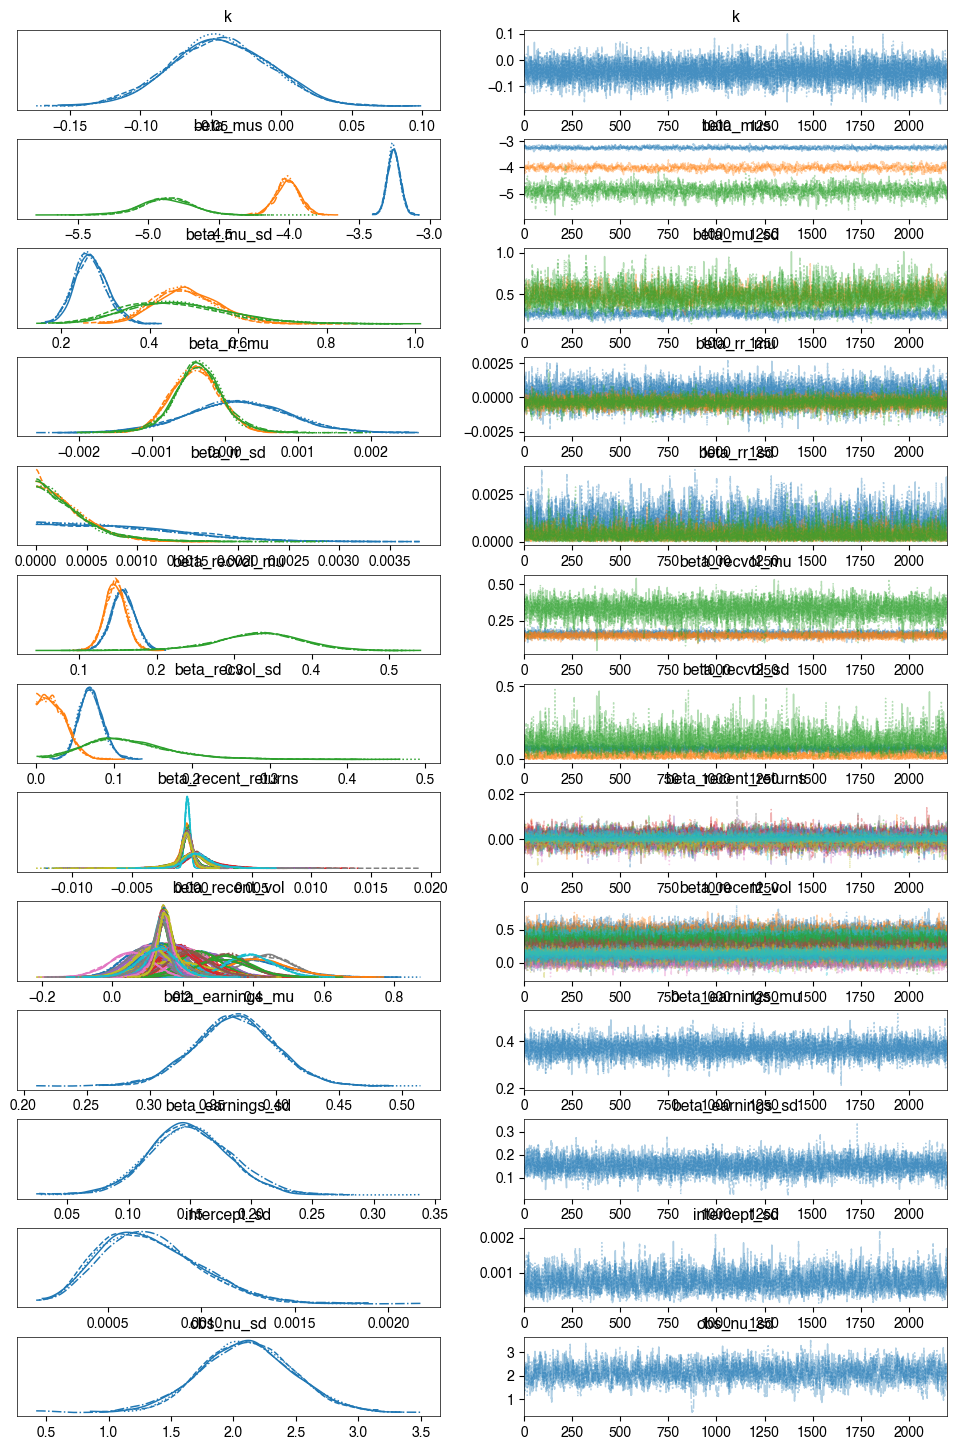

In [10]:
with model.model:
    fig, axs = plt.subplots(nrows=len(model.traceplot_vars),
                            ncols=2,
                            figsize=(12, 18),
                            gridspec_kw={'hspace': .37})
    az.plot_trace(model.trace, var_names=model.traceplot_vars, axes=axs)

### Create charts from paper
Due to stochastic nature of sampling-based inference, they won't match exactly

In [11]:
def quantiles(array, axis, index):
    g_ = pd.DataFrame({
            'q10': np.quantile(array, .10, axis=axis),
            'q25': np.quantile(array, .25, axis=axis),
            'q50': np.quantile(array, .50, axis=axis),
            'q75': np.quantile(array, .75, axis=axis),
            'q90': np.quantile(array, .90, axis=axis),
        }, index=index)
    return g_

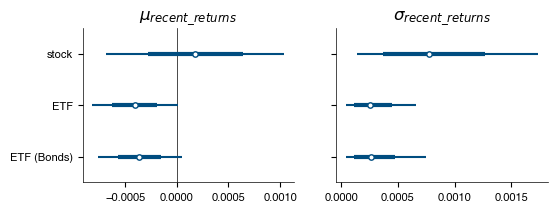

In [12]:
fig, axs = plt.subplots(figsize=(6, 2), ncols=2, sharey=True)
ax=axs[0]
beta_rr_mu = model.trace.posterior['beta_rr_mu'].stack(sample=['chain', 'draw'])
g_ = quantiles(beta_rr_mu, axis=1, index=model.coords['asset_class'])
g_ = g_.reset_index().rename(columns={'index': 'asset_class'})
g_.loc[g_.asset_class == 'etf', 'asset_class'] = 'ETF'
g_.loc[g_.asset_class == 'etf_fi', 'asset_class'] = 'ETF (Bonds)'
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels(g_.asset_class.values)
ax.set_ylim(-.5, 2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
ax.set_title(r'$\mu_{recent\_returns}$')
ax.axvline(0, c='black', linewidth=0.5, zorder=0.2)

ax=axs[1]
beta_rr_mu = model.trace.posterior['beta_rr_sd'].stack(sample=['chain', 'draw'])
g_ = quantiles(beta_rr_mu, axis=1, index=model.coords['asset_class'])
g_ = g_.reset_index().rename(columns={'index': 'asset_class'})
g_.loc[g_.asset_class == 'etf', 'asset_class'] = 'ETF'
g_.loc[g_.asset_class == 'etf_fi', 'asset_class'] = 'ETF (Bonds)'
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels(g_.asset_class.values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
ax.set_title(r'$\sigma_{recent\_returns}$')
#ax.axvline(0, c='black', linewidth=0.5, zorder=0.2)


ax.invert_yaxis()
fig.savefig(os.path.join(m6_public.ROOT, 'charts', 'mu_recent_returns_by_class.png'))

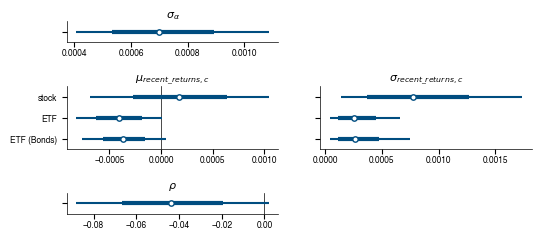

In [13]:
ncols=2
nrows=3
title_params = {'fontsize': 8, 'pad': 0}

fig, axs = plt.subplots(figsize=(6, 2.5), 
                        ncols=ncols, 
                        nrows=nrows, sharey="row", 
                        height_ratios=[.2, .6, .2, ], gridspec_kw={'hspace': 1.25})

this_row = 0
ax=axs[this_row][0]
foo_samples = model.trace.posterior['intercept_sd'].stack(sample=['chain', 'draw'])
g_ = quantiles(foo_samples, axis=0, index=['foo']).reset_index()
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels([None])
ax.set_title(r'$\sigma_{\alpha}$', **title_params)
fig.delaxes(axs[this_row][1])

this_row += 1

ax=axs[this_row][0]
beta_rr_mu = model.trace.posterior['beta_rr_mu'].stack(sample=['chain', 'draw'])
g_ = quantiles(beta_rr_mu, axis=1, index=model.coords['asset_class'])
g_ = g_.reset_index().rename(columns={'index': 'asset_class'})
g_.loc[g_.asset_class == 'etf', 'asset_class'] = 'ETF'
g_.loc[g_.asset_class == 'etf_fi', 'asset_class'] = 'ETF (Bonds)'
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels(g_.asset_class.values)
ax.set_ylim(-.5, 2.5)

ax.set_title(r'$\mu_{recent\_returns,c}$', **title_params)
ax.axvline(0, c='black', linewidth=0.5, zorder=0.2)

ax=axs[this_row][1]
beta_rr_mu = model.trace.posterior['beta_rr_sd'].stack(sample=['chain', 'draw'])
g_ = quantiles(beta_rr_mu, axis=1, index=model.coords['asset_class'])
g_ = g_.reset_index().rename(columns={'index': 'asset_class'})
g_.loc[g_.asset_class == 'etf', 'asset_class'] = 'ETF'
g_.loc[g_.asset_class == 'etf_fi', 'asset_class'] = 'ETF (Bonds)'
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels(g_.asset_class.values)
ax.set_title(r'$\sigma_{recent\_returns,c}$', **title_params)
#ax.axvline(0, c='black', linewidth=0.5, zorder=0.2)
ax.invert_yaxis()


this_row += 1

ax = axs[this_row][0]
rho_samples = model.trace.posterior['k'].stack(sample=['chain', 'draw'])
g_ = quantiles(rho_samples, axis=0, index=['rho']).reset_index()
ax.hlines(y=g_.index.values, xmin=g_.q10.values, xmax=g_.q90.values, color=(0/255, 77/255,128/255))
ax.hlines(y=g_.index.values, xmin=g_.q25.values, xmax=g_.q75.values, linewidths=3, color=(0/255, 77/255,128/255))
ax.scatter(y=g_.index.values, x=g_.q50.values, s=15, c='white', edgecolors=(0/255, 77/255,128/255), zorder=10.5)
ax.set_yticks(g_.index.values)
ax.set_yticklabels([None])
ax.set_title(r'$\rho$', **title_params)
ax.axvline(0, c='black', linewidth=0.5, zorder=0.2)



fig.delaxes(axs[this_row][1])


for i in np.arange(nrows):
    for j in np.arange(ncols):
        ax = axs[i][j]
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_tick_params(pad=1)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(6)


fig.savefig(os.path.join(m6_public.ROOT, 'charts', 'big_chart_mu_it.eps'))

For the next chart, we have to sample from the posterior predictive

In [14]:
model.sample_ppc()

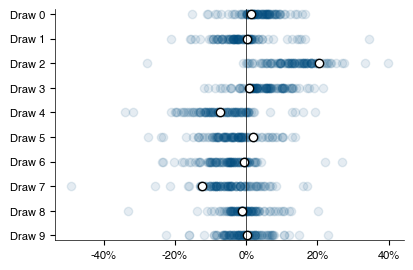

In [15]:
fig, ax = plt.subplots(figsize=(4.5, 3))
for j, i in enumerate(np.random.choice(8800, 10)):
    sample = model.ppc['obs'][i]
    mask = model.df.period_i == model.df.period_i.max()
    mask_ = mask & (model.df.symbol_i != 63)
    ax.scatter(model.ppc['obs'][i][mask_], np.repeat(j, mask_.sum()), 
               color=(0/255, 77/255,128/255), 
               alpha=.1, 
               edgecolor=(0/255, 77/255,128/255))

    mask_ = mask & (model.df.symbol_i == 63)
    ax.scatter(model.ppc['obs'][i][mask_], np.repeat(j, mask_.sum()), 
               color="white", 
               #alpha=.1, 
               edgecolor="black")
    
ax.axvline(0, c='black', linewidth=0.5)
ax.set_yticks(np.arange(10))
ax.set_yticklabels([f'Draw {j}' for j in np.arange(10)])
ax.set_ylim(-.2, 9.2)
ax.invert_yaxis()
ax.xaxis.set_major_formatter(percent_formatter)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
fig.savefig(os.path.join(m6_public.ROOT, 'charts', 'draws.png'))

Create an example submission, and accompanying chart

In [16]:
submission = model.create_submission()

/Users/weitzenfeld/PycharmProjects/m6_public/m6_public/m6_models.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_.groupby(["symbol_i", "q"]).size().unstack()


In [17]:
submission = submission.sort_values(by='q2', ascending=False)
submission.head()

,q0,q1,q2,q3,q4,total,symbol,is_stock,symbol_i,asset_class_alt,asset_class_i
0,0.001023,0.197841,0.626250,0.174205,0.000682,8800,IVV,False,0,ETF,1
81,0.011364,0.260909,0.459091,0.259659,0.008977,8800,SPMV.L,False,81,ETF,1
59,0.050000,0.283068,0.348977,0.273409,0.044545,8800,IUVL.L,False,59,ETF,1
34,0.056932,0.274545,0.341818,0.265000,0.061705,8800,EWL,False,34,ETF,1
68,0.052955,0.281136,0.340909,0.273182,0.051818,8800,MVEU.L,False,68,ETF,1


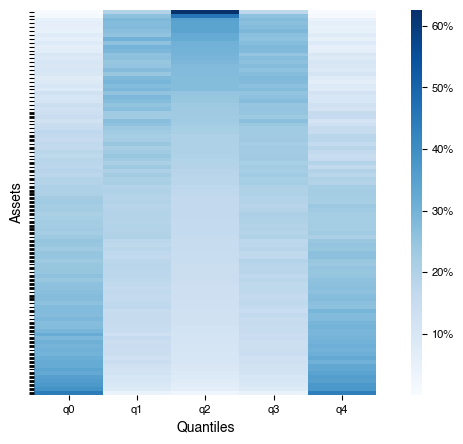

In [18]:
fig, axs = plt.subplots(figsize=(5, 5), nrows=1, ncols=2, width_ratios=[.97, .03])
sns.heatmap(submission[['q0', 'q1', 'q2', 'q3', 'q4', ]], 
            cmap='Blues', 
            ax=axs[0],
            cbar_ax=axs[1],
            cbar_kws={'format': percent_formatter})

ax = axs[0]
ax.set_ylabel('Assets')
ax.set_xlabel('Quantiles')
ax.set_yticks(np.arange(99)+.5);
ax.tick_params(labelleft=False)
for j, tick in enumerate(ax.get_yticklines()):
    if j % 2:
        continue
    if submission.asset_class_alt.values[int(j/2)] == 'stock':
        tick.set_markeredgewidth(2)

for ax in axs:
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(8)
fig.savefig(os.path.join(m6_public.ROOT, 'charts', 'forecast.png'))